# Module 0: Generation of synthetic metabolomics & proteomics time-series data based on predetermined models

# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name= '12strains_initial_design_seed1_' #'MM_4ptPerHr_'
all_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']
all_metabolites = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

# Import needed libraries

In [2]:
from IPython.display import display
import pandas as pd
from plot import *
import seaborn as sns
import math

# Define kinetic model

ODEs of limonene pathway reactions as provided by Costello et al. 2018 & in the same order. 

Provided here to facilitate understanding & reconstruction of ODEs.

In [3]:
from KineticLearning import leaky_hill_fcn, proteomicsData
    
def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                  s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                  k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                  k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                  k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
    #HC: 53 parameters (9+10+12+12+10)
    r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
    r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s6 + k44*s4 + k45) # k43*s6 NOT s5
    r5 = k41*e4*s4 / (k42*s9 + k43*s6 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5) # k43*s6 NOT s5
    r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
    r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
    r10 = k91*e9*s9 / (k92 + s9)
    return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

def kinetic_model_xtk(s,t,k):

    # Return rate of reaction vector (r1, r2, ..., r10) based on e,s,kr
    # s: metabolites conc vector
    # t: time point for getting enzymes conc
    # k: rate law parameters vector ('ke' followed by 'kr')
    
    #print('len of param vec',len(k))
    #print('KineticCoefficients',k[3*9:],len(k[3*9:]))
    #print('Proteomics',k[:3*9],len(k[:3*9]))
    
    # get e
    ke = k[:3*9] #HC: 3 ke values for each of 9 enzymes
    e = proteomicsData(t,ke)
    
    # get kr
    kr = k[3*9:] #HC: rest of k are krs
    #HC: check e,s,kr
    #print(len(e),len(x),len(kr))

    return kinetic_model(*e,*s,*kr) # list of 'r' 

# * SET rate constant kr

In [4]:
# Underlying Kr
kr = [
    1e+01, 10**8.5,10**8.5, # AtoB
    1e+02, 10**9, 10**9, 10**9, # HMGS
    1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
    1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
    1e+02, 1e+08, # PMK
    1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
    1e+01, 1e+07, # IDI 
    1e+03, 1e+06, 1e+08, 1e+08, # GPPS
    1e+01, 1e+08, # LS
    0.05, 10**0.1] # Vin set to 0.05, ks3

#G3PCX_MM_predict_30mins_woAugment__Salvgo53
# kr=[12.249794599814333,
#  388160105.0004492,
#  387342264.0062811,
#  5.61505869031139,
#  64669675.73631207,
#  66235005.493073665,
#  79078016.35809003,
#  4.300351052654894,
#  4595717.027647343,
#  5612162.058193444,
#  3192876.7174923127,
#  4305152.23632164,
#  28.438552235536594,
#  22951893.497071993,
#  9876994.45606166,
#  61860774.53467485,
#  30358276.81516579,
#  100.26002148271701,
#  102551693.53016345,
#  13.696638286654746,
#  141180608.69227558,
#  144046458.9656884,
#  137263542.61193705,
#  13804982.909885291,
#  5.688048882247,
#  5784296.6345550185,
#  408.90190136712806,
#  412175.2784468551,
#  41500104.15322663,
#  41368452.63707604,
#  35.117777805076216,
#  353198746.2830949,
#  0.05, 1.4801445145680407]

# 1 hrly wo augment SRES
# kr=[3.3460065747806413,
#  106607884.80957624,
#  105616258.08774601,
#  7.887640652521176,
#  232839014.9742311,
#  220203178.4359031,
#  255604934.28320915,
#  16.448038353375427,
#  22045631.478199195,
#  18287345.077777237,
#  28832071.081930477,
#  16522319.39596863,
#  24.108463548815127,
#  24851393.72413213,
#  2603466.137634414,
#  71667572.8671974,
#  27615099.773239322,
#  34.94985004134655,
#  41495783.26707436,
#  10.711995214837025,
#  115717764.02523664,
#  100039100.16430274,
#  125634703.74511391,
#  12672672.844191585,
#  123.26119674856432,
#  138318506.18854618,
#  517.0231547932697,
#  600653.6539173877,
#  62022549.82588269,
#  51114549.01234213,
#  14.22971035063916,
#  149191451.75039512,
#  0.05, 3.4710257325119693]

# 2 hrly pt wo augment SRES
# kr=[4.859661207102135,
#  154100350.5524576,
#  154008609.58602124,
#  2.56442473189546,
#  319486815.1241803,
#  332423659.90555525,
#  428351560.44408816,
#  13.760514532872966,
#  16292421.856681712,
#  18956680.62576625,
#  10495617.540607082,
#  13676402.803062597,
#  27.770325273522648,
#  19326944.818106852,
#  6120980.698139961,
#  68191861.08629908,
#  31267295.87848613,
#  43.69365581641304,
#  45810357.044467054,
#  21.52776249025497,
#  215320655.53288755,
#  221625548.44371983,
#  222863758.278775,
#  22433444.072363377,
#  12.222530978287159,
#  12581771.491868041,
#  99.7969158627641,
#  104150.22759584729,
#  10300233.10454042,
#  9973346.779652592,
#  19.138058891968434,
#  193691558.36675698,
#  0.05, 16.172891513087137]

# 2 hrly point wo augment, 7.5% noise
# kr=[14.484670380826332,
#  472077182.89424485,
#  393098711.23677003,
#  2.4880023040868755,
#  93233635.674739,
#  75320270.8972964,
#  63141621.421345085,
#  7.58800223263346,
#  8785310.727699077,
#  10990024.06318993,
#  16689101.142625613,
#  7296983.2610182995,
#  68.29512695255859,
#  61792154.788160995,
#  9149003.421285577,
#  148484509.95372662,
#  78733339.6377908,
#  67.9350735611992,
#  78406632.19884877,
#  9.627170055943054,
#  101762691.10489054,
#  102711507.47953582,
#  110447951.83828118,
#  11064696.519263996,
#  10.39688491385504,
#  11644689.157511486,
#  1749.3239817862923,
#  1899582.55845713,
#  176953199.6851323,
#  205324669.9225323,
#  30.316827314669233,
#  329514047.21031386,
#  0.05, 3.982006638057981]

# 1 hrly point wo augment
# kr=[5.503531205845771,
#  175339926.4320538,
#  173736370.0364849,
#  4.991453657683082,
#  289525499.8020759,
#  272164643.92539525,
#  315592259.9090763,
#  3.611704719418988,
#  4627261.854048733,
#  4196003.676050386,
#  5774401.222588112,
#  3685963.6952084783,
#  24.301360982322173,
#  25320062.69287638,
#  2880814.471459475,
#  72199160.8633649,
#  27763405.73987159,
#  115.54554356802524,
#  137203353.56874707,
#  8.288232652884627,
#  89545282.9975948,
#  77457704.68530941,
#  97196109.13543008,
#  9805473.643497936,
#  3.0891474852783043,
#  3466751.48294808,
#  636.3221680193803,
#  739018.5335008572,
#  76322211.04459672,
#  62938400.74084778,
#  38.91368956677703,
#  408002035.7190128,
#  0.05, 6.791756910802882]

# 2 hourly datapoint wo augment
# kr=[4.879762104150187,
#  154798750.20216095,
#  154436128.7630702,
#  3.7213176261332634,
#  36657707.64937024,
#  38445244.45023595,
#  50423991.781559214,
#  10.460247166862807,
#  12221523.76687265,
#  14749621.984535148,
#  7264455.203175714,
#  10425484.81363926,
#  23.064130322024457,
#  15642265.391909445,
#  4934529.314595252,
#  56378839.22405732,
#  26062831.724530958,
#  20.166534638710576,
#  21145193.967243124,
#  18.038880989170703,
#  180452858.78548685,
#  185702276.04453078,
#  186759633.64618975,
#  18798585.84651011,
#  13.83162799604501,
#  14239017.922584126,
#  1385.53184913475,
#  1446110.146561394,
#  143095033.2834513,
#  138400210.289016,
#  21.187785617388286,
#  214441403.01536304,
#  0.05, 1.2888976543818667]

# CMAES 0%
# kr=[24.341789735521008,
#  770498125.8205624,
#  770570407.5724835,
#  12.908875333819209,
#  132592743.46920629,
#  133575801.8762858,
#  141293006.60228273,
#  424.93710028362716,
#  442135703.5425901,
#  456653562.42972904,
#  419571638.0456757,
#  423088262.0675533,
#  418.4182512136561,
#  399511667.0585313,
#  295765924.2568549,
#  630922748.6327578,
#  425263543.22326005,
#  52.30576320117826,
#  52712159.6627699,
#  41.87389502844566,
#  423451241.0170319,
#  429079540.3031055,
#  418655405.8159361,
#  41936478.920335196,
#  14.986457048553103,
#  15080654.257682588,
#  96.41112339205266,
#  96442.22396102108,
#  9680414.94191425,
#  9708703.393288838,
#  7.524098862986353,
#  75389602.47928162,
#  0.05, 1.3006165019270226]

# G3PCX 0%
# kr=[3.6351947292324485,
#  115040453.92273255,
#  115163722.2248276,
#  2.8063985890112697,
#  46314456.28960049,
#  46604964.696806125,
#  49667174.39423882,
#  9.673110746568891,
#  9705570.75480753,
#  10736195.471524585,
#  8570941.482549246,
#  9724493.715638496,
#  19.556727000796013,
#  18597193.07862987,
#  13868044.822806895,
#  29447279.82855708,
#  19881770.362996854,
#  102.9305736860309,
#  103724537.41596366,
#  12.636525652524107,
#  127763677.3410062,
#  129472298.09439813,
#  126345450.03078298,
#  12655637.402536748,
#  11.771573085187299,
#  11845204.69243916,
#  709.714731592793,
#  710034.7431967282,
#  71268030.41474967,
#  71450699.79451951,
#  17.013729615883385,
#  170468722.54810506,
#  0.05, 2.0897902726400983]

# ISRES 0%
# kr=[4.015807902374604,
#  127113600.40900286,
#  127125517.348282,
#  4.208826565487971,
#  306752541.76707953,
#  309026810.8468508,
#  326880517.36875254,
#  5.856264317444886,
#  6093286.89266397,
#  6293365.717145127,
#  5782320.412682495,
#  5830784.446852674,
#  23.38143992757912,
#  22324923.531763446,
#  16527551.914786907,
#  35256309.77033088,
#  23763960.03511419,
#  18.585110888456335,
#  18729510.048372008,
#  42.636525536138805,
#  431163362.317284,
#  436894167.2110984,
#  426280195.878497,
#  42700249.56817559,
#  31.607230480519043,
#  31805897.37623234,
#  8278.871339176154,
#  8281542.151262955,
#  831262112.7116727,
#  833691173.1119242,
#  7.724826904418006,
#  77400847.02240579,
#  0.05, 9.228795444675196]

# SRES 0%
# kr=[2.080969971343917,
#  65869580.36105407,
#  65875755.148932,
#  7.5065935849636345,
#  315217081.22182375,
#  317554104.1180506,
#  335900466.2482879,
#  32.25588014253787,
#  33561383.59515718,
#  34663403.82466921,
#  31848606.131871734,
#  32115538.612363648,
#  16.655783486004715,
#  15903172.876542434,
#  11773410.77021682,
#  25114854.511483587,
#  16928272.185834568,
#  46.010463329012026,
#  46367947.99157464,
#  15.291238425189105,
#  154633179.82594472,
#  156688491.6956186,
#  152881878.36950904,
#  15314092.641533779,
#  25.031964256311316,
#  25189302.38928925,
#  827.3518010877931,
#  827618.728651611,
#  83072461.0287013,
#  83315206.80590378,
#  20.243637879636214,
#  202836225.34361023,
#  0.05, 5.317221024908019]

#CMAES 2.5%
# kr=[9.168268398656936,
#  289959413.9662518,
#  292562132.76786494,
#  5.12732961543803,
#  62090257.84062828,
#  62111721.06158142,
#  63812888.96934867,
#  728.0302363181644,
#  822047393.5458022,
#  756605469.8211153,
#  981934215.612558,
#  717473398.1814942,
#  9.153874479554217,
#  9065248.4240556,
#  3882582.7439654474,
#  17900373.52033199,
#  9521752.164864026,
#  369.2212373015598,
#  384607341.5667877,
#  1.4181092407438438,
#  14194598.407199621,
#  14268849.151259892,
#  14783552.003252624,
#  1479091.3707540527,
#  206.9407267777704,
#  212320782.777641,
#  23.487125443435552,
#  24344.313381041153,
#  2385985.0051716026,
#  2368990.650143959,
#  59.686282938929395,
#  605745235.213676,
#  0.05, 1.5120121850439698]

#G3PCX 2.5%
# kr=[5.114013459044473,
#  161657253.74279726,
#  163505470.1151922,
#  5.402315453058239,
#  165865905.2571188,
#  165543163.41181207,
#  172876805.95820245,
#  13.13467738266598,
#  13939747.163002105,
#  14475238.008705467,
#  15416109.863212792,
#  13186376.247614527,
#  34.729937626212376,
#  34913452.99442153,
#  15873658.275101893,
#  67097248.83868542,
#  35981679.70634683,
#  163.4418037971583,
#  170363882.95152897,
#  8.059694926874732,
#  80726648.67241962,
#  81141120.36895455,
#  84044571.38035451,
#  8409364.425504059,
#  7.226226221999506,
#  7417259.83889776,
#  3239.127600124352,
#  3357829.111430553,
#  328989878.30890876,
#  326957236.0087967,
#  6.52355943220348,
#  66218271.477754384,
#  0.05, 3.8339002565113756]

# ISRES 2.5%
# kr=[15.952005106778014,
#  504504657.589211,
#  509033111.69165105,
#  3.0419209226133406,
#  142528606.80549517,
#  142577893.28356564,
#  146482995.7886475,
#  157.81527629561248,
#  178195386.8104642,
#  164009469.30190763,
#  212854124.51413622,
#  155526870.53151372,
#  20.5769718445255,
#  20377751.25641081,
#  8727648.894763047,
#  40238205.72077568,
#  21403922.67424354,
#  13.973371001825061,
#  14555665.948464986,
#  9.76659525141504,
#  97758969.14202952,
#  98270335.78095682,
#  101815125.28420931,
#  10186582.574132632,
#  9.281122894129314,
#  9522413.94671659,
#  347.6234509949857,
#  360310.3382355493,
#  35314004.11888847,
#  35062472.93244163,
#  2.2335683827345547,
#  22668079.303334482,
#  0.05, 5.850287826577263]

# SRES 2.5%
# kr=[8.975158426378496,
#  283852042.3231981,
#  286399916.26888925,
#  3.215650423019069,
#  283084375.7167331,
#  283182266.4643409,
#  290938433.85724247,
#  37.09933627952514,
#  41890307.98018201,
#  38555475.18083972,
#  50037910.57864541,
#  36561376.37669976,
#  21.897005628345255,
#  21685005.168676797,
#  9287536.281546507,
#  42819529.07601466,
#  22777006.374168552,
#  17.321747889104998,
#  18043575.4514243,
#  10.394819919779406,
#  104047196.61428265,
#  104591459.50495079,
#  108364263.42219229,
#  10841822.512655906,
#  58.77967899592992,
#  60307836.2106872,
#  2558.2858770813655,
#  2651653.1979826503,
#  259888448.63251185,
#  258037334.28627422,
#  4.393884264226889,
#  44592732.29379582,
#  0.05, 10.991834565312654]

# ISRES 5% noise
# kr=[1.6748506006289392,
#  51606646.259696074,
#  60104778.359418094,
#  6.861267739920871,
#  185405303.6696277,
#  193500128.0118483,
#  224748328.25211096,
#  5.256898761160931,
#  5742423.6990770595,
#  6070882.490829237,
#  6029647.312061429,
#  5344359.694237936,
#  22.68902933732074,
#  23713434.740501437,
#  11972444.33962037,
#  36636517.64834937,
#  23783579.801765464,
#  86.58494325597667,
#  90840403.92693076,
#  35.44440769501024,
#  347361538.78029394,
#  355194432.6593976,
#  379018620.56220675,
#  37488371.9299226,
#  23.8355634851991,
#  24940270.720816813,
#  644.1567914652064,
#  661010.8781615463,
#  67511086.89954446,
#  66708422.39042684,
#  14.025723616410007,
#  141915870.89014164,
#  0.05, 3.48224296760188]

# SRES 5% noise
# kr=[6.313767374996461,
#  194544132.39260918,
#  226579976.10849997,
#  2.541132808144382,
#  154400556.0330337,
#  161141735.4897673,
#  187164461.90423548,
#  97.56160132898954,
#  106572350.22874478,
#  112668140.495579,
#  111902892.72778682,
#  99184766.0625502,
#  8.081021954668547,
#  8445878.704250969,
#  4264157.100823076,
#  13048619.383493172,
#  8470861.610294955,
#  42.120404831711596,
#  44190530.3073232,
#  17.08435196466488,
#  167429704.21391582,
#  171205191.5920588,
#  182688551.9025915,
#  18069550.813116916,
#  20.0697715947047,
#  20999945.614363756,
#  479.08967718443154,
#  491624.8610447029,
#  50211168.31470708,
#  49614187.47123159,
#  6.428273260832142,
#  65042919.00243991,
#  0.05, 7.830019554696783]

# G3PCX 5% NOISE
# kr=[4.786149829549998,
#  147437042.29373872,
#  171870495.8817357,
#  2.1707662128581284,
#  116261495.0291353,
#  119448767.60319336,
#  136593306.05656204,
#  11.330143142214162,
#  11485827.159572639,
#  13821821.605029417,
#  11149173.229527298,
#  11751705.696216227,
#  16.432034320390628,
#  17579091.634837996,
#  9277033.182417948,
#  26307705.00339501,
#  17125190.581462327,
#  83.10645103586901,
#  87238028.69596525,
#  6.535298016664662,
#  64050778.10033872,
#  65501315.15894433,
#  69919606.15588528,
#  6915571.990767428,
#  7.560646506062875,
#  7913645.043998155,
#  2146.1893395615425,
#  2204939.088974819,
#  225143541.54647103,
#  222081065.9584635,
#  36.929362163301676,
#  373738596.19413805,
#  0.05, 6.814378513197615]

# CMAES 5% noise
# kr=[25.272783093472082,
#  778722303.0820987,
#  906955606.8923908,
#  5.007440693653092,
#  596713902.9437848,
#  648199805.9263284,
#  697624905.4539112,
#  42.128662531767894,
#  49227941.97244647,
#  146329.23169619267,
#  74032.59512589528,
#  43958850.43227558,
#  86.72403778810393,
#  91495432.97771057,
#  43951899.5987797,
#  141140033.65842223,
#  90857422.01531622,
#  77.02232410226699,
#  80793862.95672566,
#  42.115359931695195,
#  412666796.5611622,
#  421972614.46538323,
#  450328610.86160576,
#  44539230.55139495,
#  275.9544912007556,
#  288711834.75697154,
#  52.273255145001585,
#  53635.42546139851,
#  5478140.038580738,
#  5413022.388217978,
#  18.844866274966776,
#  190669481.98407868,
#  0.05, 15.713351611335092]

# ISRES 7.5% noise
# kr = [4.257477158788692,
#  130649999.78038883,
#  158754798.10310704,
#  6.253277523852371,
#  193785648.20973185,
#  223171538.13459128,
#  276433733.9139358,
#  26.16715699216635,
#  32393932.780493215,
#  30171927.813968264,
#  30364174.364154868,
#  26146716.018130008,
#  13.841063464749922,
#  10934854.701672897,
#  5309550.999595971,
#  20720873.05219635,
#  15922842.524816092,
#  37.628822929903144,
#  40728618.572758056,
#  69.12728710016015,
#  759214394.0277916,
#  769195591.8016431,
#  713982510.127409,
#  72101640.0304237,
#  41.4133583169845,
#  44111699.474764474,
#  107.05853759057187,
#  105392.16030313057,
#  10754535.397291178,
#  11845243.331507131,
#  18.941936367501558,
#  193513783.1316113,
#  0.05, 4.280536684466626]

# SRES 7.5% noise
# kr= [2.5639814570473294,
#  78681379.67778572,
#  95606935.956585,
#  2.2443680795331726,
#  112994460.60658759,
#  130129078.18909836,
#  161185733.53776032,
#  95.07089301756643,
#  117694097.59007001,
#  109621072.47514649,
#  110319523.32998522,
#  94996630.22086348,
#  23.297709550273115,
#  18405887.222478315,
#  8937204.935157327,
#  34878018.47066636,
#  26801824.55691605,
#  18.033426191253103,
#  19518987.832060333,
#  39.16240700957948,
#  430114724.10589254,
#  435769322.5205034,
#  404489668.5184004,
#  40847455.031265005,
#  5.747722867473234,
#  6122223.123310849,
#  16.94340453372139,
#  16679.678677546333,
#  1702044.928992395,
#  1874663.6279751095,
#  6.301398133834775,
#  64376067.447379224,
#  0.05, 6.954203416108272]

# mean kr from 3 CMAES seeds for 7.5% noise
# kr=[18.90356434893431,
#  580097223.2906843,
#  704884936.9433186,
#  4.52205695065174,
#  330724686.409708,
#  391227757.24708277,
#  510077511.57174224,
#  672.9625242082301,
#  869067241.5079789,
#  806964314.8400626,
#  678455649.7290957,
#  663102135.6838393,
#  28.807845686060503,
#  53543.882916650844,
#  6037230.860112401,
#  39756151.17238413,
#  35045396.399643704,
#  8.571992552194114,
#  9275071.153922342,
#  5.139177820669817,
#  56424568.948431954,
#  57165889.21570655,
#  53075277.88465081,
#  5359257.528018084,
#  671.1667090773975,
#  714745769.2300979,
#  270.60774773412743,
#  266347.4562008611,
#  27180411.657585137,
#  29936656.671371736,
#  11.617458496755047,
#  118676982.86143655,
#  0.05, 10.369520471751004]

# mean kr from 3 G3PCX seeds for 7.5% noise
# kr=[3.479213047599239,
#  106758862.22233589,
#  129797262.58859053,
#  2.4749354516858055,
#  79223915.59274432,
#  93008261.49994448,
#  118195010.43646741,
#  27.365303974946123,
#  33840691.072298326,
#  32047333.510049447,
#  30184863.528538927,
#  27354810.46497765,
#  32.779699402180334,
#  25096674.616974432,
#  12082969.799536085,
#  48291198.80365648,
#  37889684.586829826,
#  97.98633861461963,
#  106089119.10664833,
#  8.884065803438531,
#  97580370.63350523,
#  98862378.16390777,
#  91774748.56308798,
#  9269490.634694032,
#  2.0995950006604196,
#  2236780.9054112914,
#  2236.7183635243364,
#  2202161.3867165456,
#  224613966.22270754,
#  247579506.73360842,
#  5.081828057020837,
#  51922943.753446594,
#  0.05, 4.497793439697595]

print (str(len(kr))+' kr parameters in same order as their input into kinetic_model function:')
print (kr)

34 kr parameters in same order as their input into kinetic_model function:
[10.0, 316227766.01683795, 316227766.01683795, 100.0, 1000000000, 1000000000, 1000000000, 100.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100.0, 100000000.0, 10.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 10.0, 10000000.0, 1000.0, 1000000.0, 100000000.0, 100000000.0, 10.0, 100000000.0, 0.05, 1.2589254117941673]


# * SET Ke parameters (kf, kl, km) for WT

e = kf * t / (km + t)   + kl <br>
where kf: maximum increase in enzyme conc <br>
km: hours required to increase the enzyme conc by 1/2*kf <br>
kl: enzyme conc at hour = 0

1. define km parameters

- km: randomly SET between 0.1 t & 9 hours

- kf: randomly initialized between 1e5 & 1e6                                              

- kl: randomly initialized between 1e1 to 1e2

In [5]:
#--- set initial parameter bounds for each enzyme
bounds = [(1e6,5e6),(0.1,1),(1e1,1e2)]*9
lower_bound = [bound[0] for bound in bounds] # reformat bounds
upper_bound = [bound[1] for bound in bounds]

# For creating replicable WT template, NOT noise !!
np.random.seed(2)

# get random kf, km, kl values based on bounds
ke = np.random.uniform(low=lower_bound,high=upper_bound)

print('km values defined...\n\nkf, kl values initialized for ' + str(int(len(ke)/3)) + ' enzymes:')
print (ke)

km values defined...

kf, kl values initialized for 9 enzymes:
[2.74397961e+06 1.23333609e-01 5.94696230e+01 2.74128957e+06
 4.78331022e-01 3.97301339e+01 1.81859454e+06 6.57343870e-01
 3.69689206e+01 2.06730910e+06 6.59020449e-01 5.76227885e+01
 1.53831978e+06 5.62220309e-01 2.65995879e+01 4.14134059e+06
 8.68577763e-01 5.44813154e+01 4.38624594e+06 1.71680929e-01
 5.54721481e+01 1.26114602e+06 4.85310095e-01 1.86877824e+01
 1.50863989e+06 6.37070778e-01 3.03410801e+01]


2. define kl parameters
- i.e., enzyme expression values at t =0 from the 3 empirical strains

3. define kf parameters

# --- SET data points requirement for synthetic data

In [6]:
# no. data points needed per hour
datapointsPerHr = 4

# no. hours required
hr = 24

# resulting total no. data points required
noDataPts=hr*datapointsPerHr + 1 # include data for time=0

# Generate array of evenly-spaced time points betw max & min time
timePoints = np.linspace(0,hr,noDataPts)

# --- SET biological noise

For all strains, affects:
- initial enzyme conc (kl values)
- initial metabolite conc

In [7]:
biologicalNoise = 0.0 # 0.025: Gaussian noise with standard deviation of 2.5% of underlying value
biologicalNoiseSeed = 0

# Explore synthetic time-series data for enzymes in WT

to appreciate effects of kf, km, kl

no. time series: 9
data points in each time series:97

AtoB


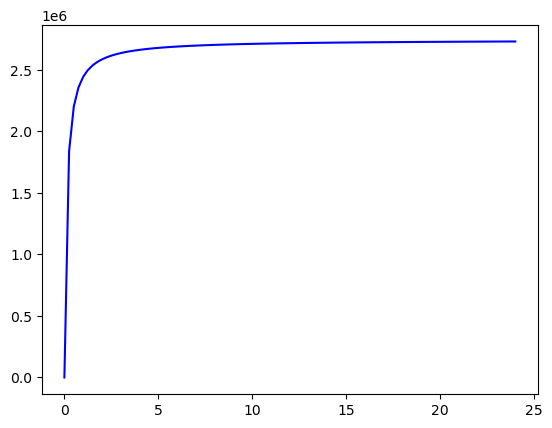

HMGS


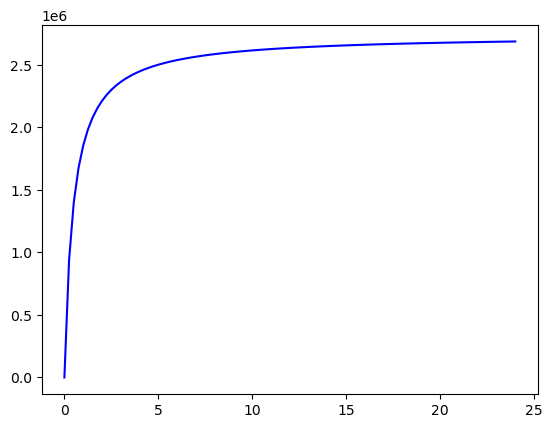

HMGR


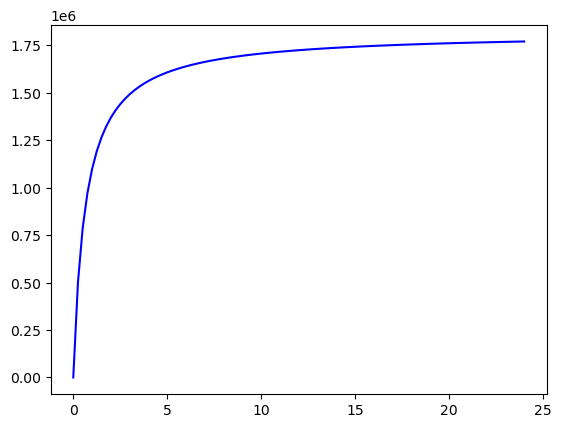

MK


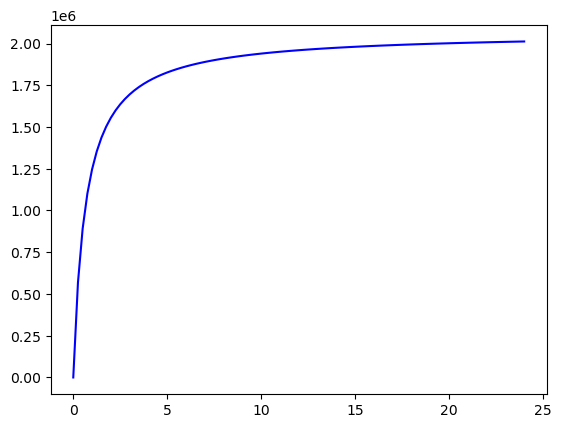

PMK


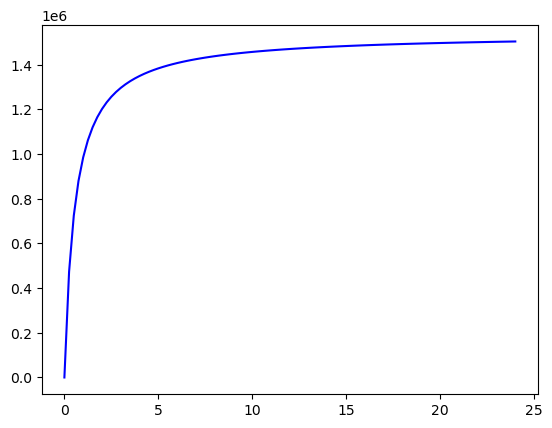

PMD


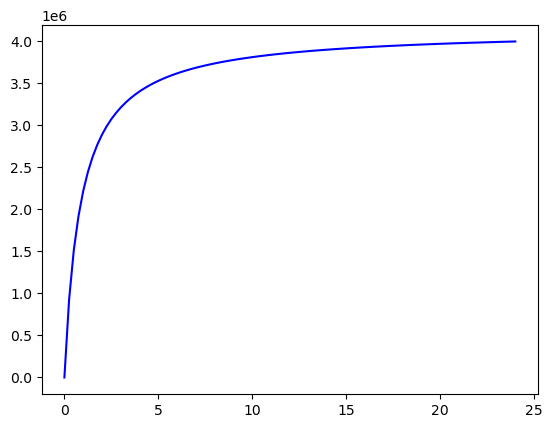

GPPS


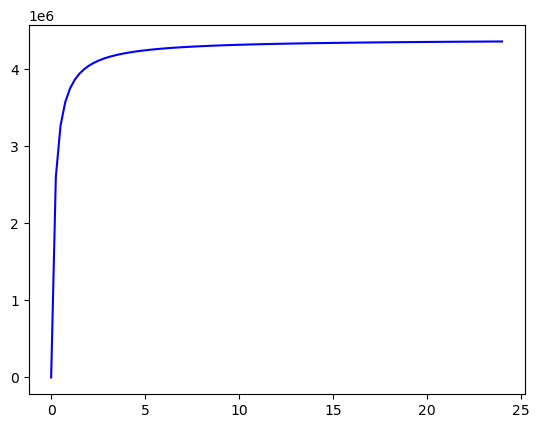

Idi


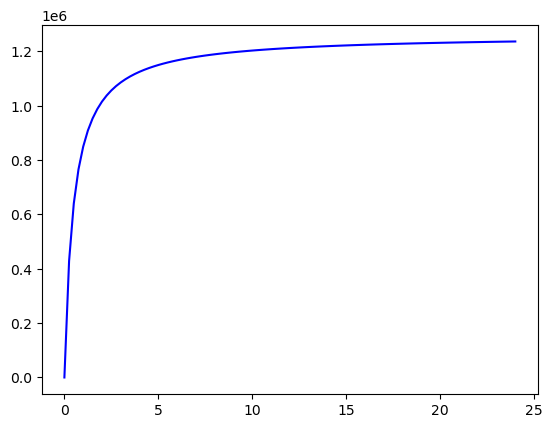

Limonene Synthase


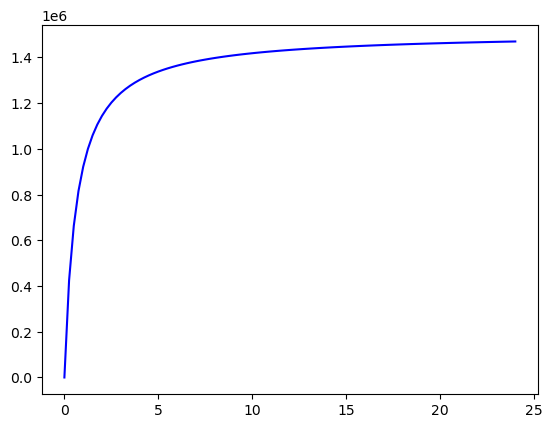

In [8]:
from KineticLearning import plotAllEnzymesTimeSeries, getAllEnzymesTimeSeries

# Evaluate time-series data for the 9 enzymes in WT 
allEnzymesTimeSeries=getAllEnzymesTimeSeries(timePoints, ke)

print('no. time series: ' + str(len(allEnzymesTimeSeries)))
print('data points in each time series:' + str(len(allEnzymesTimeSeries[1])) + '\n')

# Plot enzyme time series profiles for sanity check of ke values 
plotAllEnzymesTimeSeries(all_enzymes, allEnzymesTimeSeries,timePoints)


# --- Read in recommended strains design
1: WT
2: over-expression
0: knockdown

In [9]:

#--- manual inclusion of strains recommendation
design={} # dictionary using strain as key to hold a list of enzyme design in same order as their conc in kinetic_model
design['WT']=[1]*9 # WT design for 9 enzymes
# design['Strain_111']=[1]*4+[2]*5 # design of 1st four enzymes= 1, last five = 2
# design['Strain_222']=[0,0,0,0,2,2,2,2,2] # design of 1st four enzymes= 0, last five = 2

###--- include strain designs from ART
# remember to remove last line from recommendation file
from KineticLearning import readARTrecommendationFile
design = readARTrecommendationFile (design, all_enzymes, '12strains_initial_design_seed1.csv')

listStrains=design.keys()


ART design for Strain 1 read in:
[2, 2, 0, 2, 0, 1, 0, 2, 0]


ART design for Strain 2 read in:
[0, 0, 2, 0, 2, 2, 1, 1, 0]


ART design for Strain 3 read in:
[2, 0, 0, 0, 1, 2, 1, 1, 0]


ART design for Strain 4 read in:
[0, 2, 2, 0, 2, 2, 0, 2, 2]


ART design for Strain 5 read in:
[2, 1, 2, 1, 0, 1, 2, 0, 1]


ART design for Strain 6 read in:
[1, 0, 1, 0, 1, 0, 2, 2, 1]


ART design for Strain 7 read in:
[2, 2, 0, 2, 0, 0, 1, 1, 2]


ART design for Strain 8 read in:
[0, 1, 1, 1, 1, 2, 2, 2, 1]


ART design for Strain 9 read in:
[1, 1, 1, 2, 0, 1, 0, 0, 1]


ART design for Strain 10 read in:
[1, 0, 2, 1, 2, 1, 2, 0, 2]


ART design for Strain 11 read in:
[0, 1, 1, 2, 2, 0, 0, 1, 0]


Completed reading of
12strains_initial_design_seed1.csv
-------------------------------------------



# Translate strains design to kf/m/l values

In [10]:
# Specify which enzyme expression parameter to design
design_K = 'kf' # 'kf', 'km', 'kl'

if design_K == 'kf':
    ke_startPosition= 0
    print ('Design parameter: kf')
elif design_K == 'km':
    ke_startPosition=1
    print ('Design parameter: km')
elif design_K == 'kl':
    ke_startPosition == 2
    print ('Design parameter: kl')
else:
    print ('WARNING; ENZYME PARAMETER K(f/l/m) TO DESIGN UNCLEAR.')

Design parameter: kf


In [11]:
#--- read enzyme conc in WT
kl_WT=[]
for i in range(ke_startPosition,len(ke),3): #every 3rd value in ke starting from ke_startPosition
    kl_WT.append(ke[i])

# PRINT OUT
print ( design_K + ' for WT read in:')
print (kl_WT)
print ('\nfrom WT ke:')
print (ke)

kf for WT read in:
[2743979.608568015, 2741289.5704731075, 1818594.53615137, 2067309.1004114666, 1538319.7813797342, 4141340.591266694, 4386245.941429872, 1261146.0175475124, 1508639.88680511]

from WT ke:
[2.74397961e+06 1.23333609e-01 5.94696230e+01 2.74128957e+06
 4.78331022e-01 3.97301339e+01 1.81859454e+06 6.57343870e-01
 3.69689206e+01 2.06730910e+06 6.59020449e-01 5.76227885e+01
 1.53831978e+06 5.62220309e-01 2.65995879e+01 4.14134059e+06
 8.68577763e-01 5.44813154e+01 4.38624594e+06 1.71680929e-01
 5.54721481e+01 1.26114602e+06 4.85310095e-01 1.86877824e+01
 1.50863989e+06 6.37070778e-01 3.03410801e+01]


In [12]:
#--- translate design to enzyme conc for recommended strains
from KineticLearning import addNoise, addNoise2

design_kl={}
print ( '9 ' + design_K + ' values translated for:\n')

# biologicalNoise = 0.05

for strain in listStrains: # go thru each strain

    if len(design[strain]) == len (kl_WT):

        designList=design[strain] # get design for all enzymes (1:unchanged, 2: upreg, 0: downreg)

        # map to actual protein levels (% of WT)
        for i in range(len(designList)): #go thru each enzyme design
            if designList[i] == 2:
                designList[i]= kl_WT[i]*2.486 # 92%/37% promoter strength, Shukal et al. 2019 virifloral paper
            elif designList[i] == 0:
                designList[i]= kl_WT[i]*0.432 # 16%/37% promoter strength
            else:
                designList[i]=kl_WT[i]*1.0 # All other design assumed to be 1 (unchanged)

        # add biological noise to kl values (initial conc)
        designList = addNoise2(designList, biologicalNoise, biologicalNoiseSeed) # 0 make biologically-noisy kl values replicable
        
        design_kl[strain]=designList # store designed kl (initial enzymes conc) for each strain
        print (strain)
        print (design_kl[strain])
    else:
        print ('Number of enzymes being accounted for in design dict for ' + strain + ' not matching kl_WT list')


9 kf values translated for:

WT
[2743979.608568015, 2741289.5704731075, 1818594.53615137, 2067309.1004114666, 1538319.7813797342, 4141340.591266694, 4386245.941429872, 1261146.0175475124, 1508639.88680511]
Strain 1
[6821533.306900086, 6814845.872196146, 785632.8396173918, 5139330.423622906, 664554.1455560451, 4141340.591266694, 1894858.2466977048, 3135208.999623116, 651732.4310998075]
Strain 2
[1185399.1909013826, 1184237.0944443825, 4521026.016872306, 893077.5313777536, 3824262.9765100195, 10295372.709889002, 4386245.941429872, 1261146.0175475124, 651732.4310998075]
Strain 3
[6821533.306900086, 1184237.0944443825, 785632.8396173918, 893077.5313777536, 1538319.7813797342, 10295372.709889002, 4386245.941429872, 1261146.0175475124, 651732.4310998075]
Strain 4
[1185399.1909013826, 6814845.872196146, 4521026.016872306, 893077.5313777536, 3824262.9765100195, 10295372.709889002, 1894858.2466977048, 3135208.999623116, 3750478.7585975034]
Strain 5
[6821533.306900086, 2741289.5704731075, 452102

# * SET initial metabolites conc

In [13]:
# initial conc -------- AcCoA,'AcAcCoA,HMG-CoA,Mev,MevP,MevPP,IPP,DMAPP,GPP,Limonene
initialMetabolitesConc = [0.3,   0.2,  0.05,  0.3, 0.02, 0.2, 0.01, 0.04, 0.05, 0] # like empirical data

# set initial limonene conc at 0, other 9 metabolites at 0.2
#initialMetabolitesConc = [0.2]*(10-1) + [0]

# biologicalNoise = 0.05
# noiseSeed =2

# add biological variations
initialMetabolitesConc = addNoise2(initialMetabolitesConc, biologicalNoise, biologicalNoiseSeed)

print ('INITIAL metabolite conc with their ordering following model reactions:\n' +str(initialMetabolitesConc))

INITIAL metabolite conc with their ordering following model reactions:
[0.3, 0.2, 0.05, 0.3, 0.02, 0.2, 0.01, 0.04, 0.05, 0.0]


# --- SET technical noise

Affects enzymes & conc measurements

Technical replicates: change 'technicalNoiseSeed' variable & rerun this & next 3 sections.

In [14]:
# Convention: technicalNoiseSeed = 0 -> no noise
#             technicalNoiseSeed = 1 -> replicate 1 with noise
#             technicalNoiseSeed = 2 -> replicate 2 with noise
#             technicalNoiseSeed = 3 -> replicate 3 with noise
# ENSURE technicalNoiseSeed & replicate variables CORRESPOND, i.e., 1 <-> '1'

technicalNoiseSeed = 0 # Any different number to generate different replicate

if technicalNoiseSeed == 0:
    noiseLevel = 0 #
else:
    noiseLevel = 75 # to change

technicalNoise = noiseLevel/1000 # Gaussian noise with standard deviation of 2.5% of underlying value
    
replicate = str(technicalNoiseSeed) + str('rep_') + str(noiseLevel) + 'noiseLevel' # Any different string to change output to a different file

print ('technical noise:' + str(technicalNoise))

technical noise:0.075


# Simulate metabolomics & proteomics time-series data for recommended strains

In [15]:
from scipy.integrate import odeint,ode
import csv

# headers for output files
CSV = [ ['Strain','Time/hours'] + all_metabolites ]
CSV2 = [ ['Strain','Time/hours'] + all_enzymes ]

sol_strain={} # dict [strain] = a list with each element holding time-series conc for a metabolite
noisy_sol_strain={} # include noise for above

#listStrains =[]
#listStrains.append('WT')



for strain in listStrains: # for each of first 8 strains
    
    designKlList=design_kl[strain]  # get its kl value for enzymes
    keList=ke # prepare its ke template

    # update ke template with its kf/m/l values
    count=0
    for i in range(ke_startPosition,len(keList),3): # every 3rd value in keList starting from ke_startPosition
        keList[i]= designKlList[count]
        count=count+1
    #'''
    print ('\nke of designed strain ' + strain + ': ')
    print (keList)
    print ('Updated using designed kl')
    print (designKlList)
    
    
    # Build customized model
    ODE = lambda metabolites,t: kinetic_model_xtk( metabolites, t, np.append(keList, kr))
    
    # Solve for metabolite conc at various timePoints based on initialMetabolitesConc
    sol = odeint(ODE,initialMetabolitesConc,timePoints).tolist()
    sol_strain [strain]=sol
    # print (sol_strain[strain])
    
    # Include measurement noise for metabolites
    sol = addNoise(sol,technicalNoise, technicalNoiseSeed)
    noisy_sol_strain [strain] = sol
    # print (str(len(sol)) + ' time-series datapoints solved for '  + str(len(sol[0])) + ' metabolites in ' + strain + ' strain')
    
    # Metabolite print format
    lines = [  [ strain,timePoints[i] ] + line for i,line in enumerate(sol)  ]
    CSV = CSV + lines
    
    # Enzyme print format
    sol2=[]
    for t in timePoints:
        e = proteomicsData(t,keList) # get vector of enzyme conc at time t
        sol2.append(e)
    # Include measurement noise for enzymes
    sol2 = addNoise(sol2, technicalNoise, technicalNoiseSeed)
    lines2 = [  [ strain,timePoints[i] ] + line for i,line in enumerate(sol2)  ]
    CSV2 = CSV2 + lines2

print (str(len(sol)) + ' time-series datapoints solved for '  + str(len(sol[0])) + ' metabolites for all strains')


ke of designed strain WT: 
[2.74397961e+06 1.23333609e-01 5.94696230e+01 2.74128957e+06
 4.78331022e-01 3.97301339e+01 1.81859454e+06 6.57343870e-01
 3.69689206e+01 2.06730910e+06 6.59020449e-01 5.76227885e+01
 1.53831978e+06 5.62220309e-01 2.65995879e+01 4.14134059e+06
 8.68577763e-01 5.44813154e+01 4.38624594e+06 1.71680929e-01
 5.54721481e+01 1.26114602e+06 4.85310095e-01 1.86877824e+01
 1.50863989e+06 6.37070778e-01 3.03410801e+01]
Updated using designed kl
[2743979.608568015, 2741289.5704731075, 1818594.53615137, 2067309.1004114666, 1538319.7813797342, 4141340.591266694, 4386245.941429872, 1261146.0175475124, 1508639.88680511]

ke of designed strain Strain 1: 
[6.82153331e+06 1.23333609e-01 5.94696230e+01 6.81484587e+06
 4.78331022e-01 3.97301339e+01 7.85632840e+05 6.57343870e-01
 3.69689206e+01 5.13933042e+06 6.59020449e-01 5.76227885e+01
 6.64554146e+05 5.62220309e-01 2.65995879e+01 4.14134059e+06
 8.68577763e-01 5.44813154e+01 1.89485825e+06 1.71680929e-01
 5.54721481e+01 3.13

# ** Output simulated strain data to file


Technical replicates: re-run previous two sections with this one.

In [16]:
# Output simulated enzyme data to file 
fileName2 = 'data/' + replicate + '_' + shelve_name + str(len(listStrains)) + 'strains_ENZYME.csv'
with open(fileName2, 'w', newline='') as csvfile2:
    writer2 = csv.writer(csvfile2)
    writer2.writerows(CSV2)
print ('\n' + fileName2 + ' created.') 

# Output simulated metabolite data to file 
fileName =  'data/' + replicate + '_' + shelve_name + str(len(listStrains)) + 'strains_METABOLITE.csv'
with open(fileName, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(CSV)
print ('\n' + fileName + ' created.')


data/0rep_75noiseLevel_12strains_initial_design_seed1_12strains_ENZYME.csv created.

data/0rep_75noiseLevel_12strains_initial_design_seed1_12strains_METABOLITE.csv created.


# convert small negative metabolite conc. values ( magnitude < 10**-7) to e-12

i.e., simulate machine error

In [17]:
df_1=pd.read_csv(fileName)

# convert any value in file to 0 if < 0
# df_1X=df_1.apply(lambda x: x.apply(lambda y: 0 if y < 0 else y) if np.issubdtype(x.dtype, np.number) else x)

# convert any value in file to e-12 if <= 0
df_1X=df_1.apply(lambda x: x.apply(lambda y: 10**-12 if y < 0.0 else y) if np.issubdtype(x.dtype, np.number) else x)
df_1X.to_csv(fileName+'.csv', index=False)

# remove earlier file
import os
os.remove(fileName)

# Explore simulated metabolite kinetics in WT

Acetyl-CoA


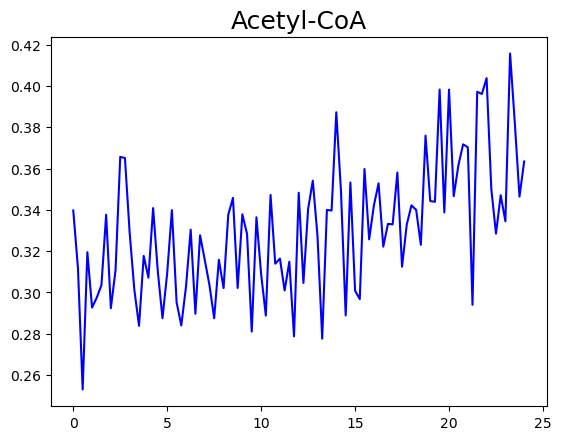

Acetoacetyl-CoA


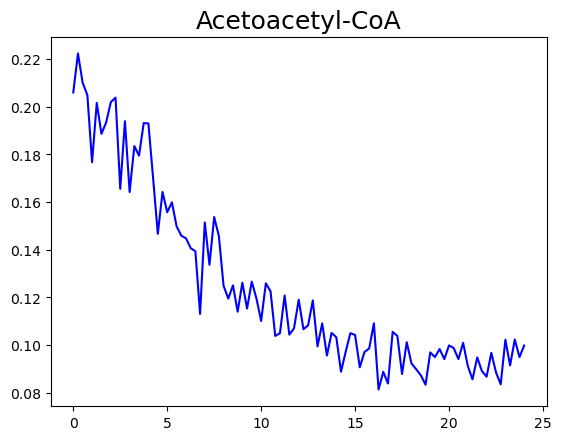

HMG-CoA


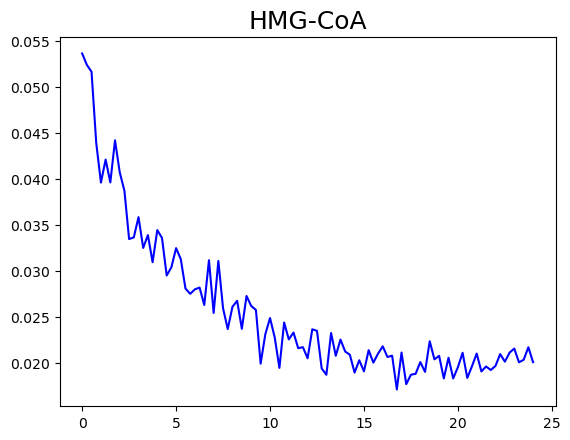

Mev


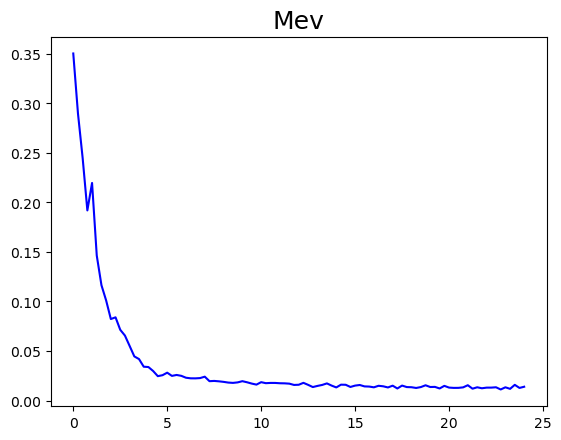

MevP


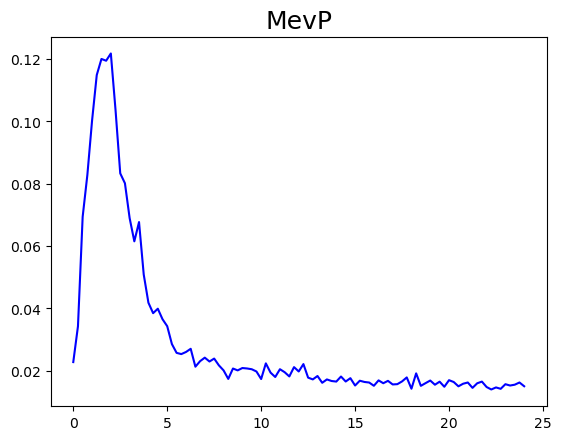

MevPP


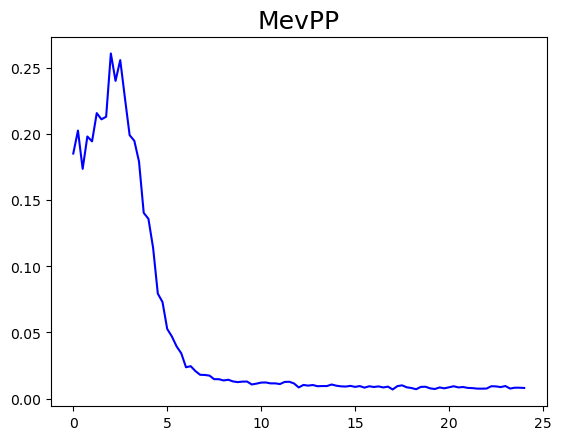

IPP


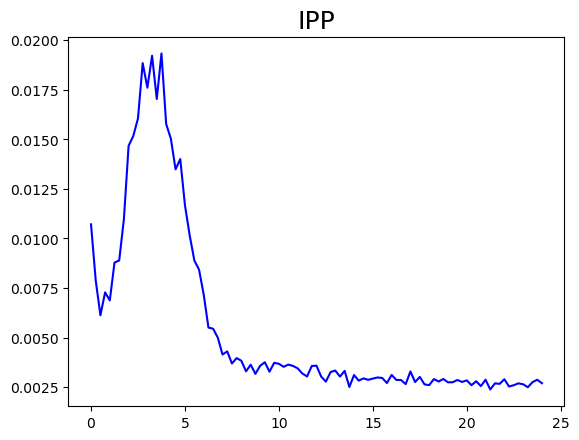

DMAPP


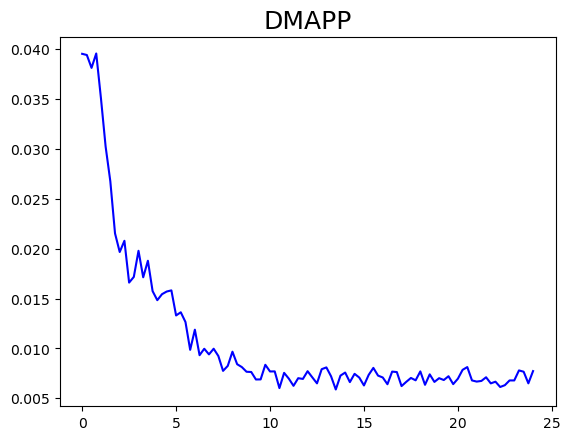

GPP


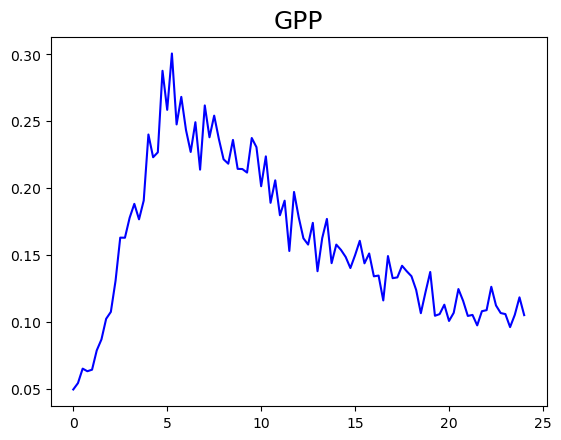

Limonene


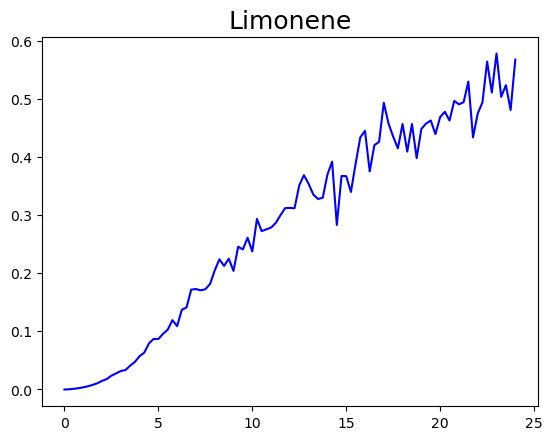

In [18]:
from KineticLearning import plotSimulatedKinetics
sol_WT = noisy_sol_strain['WT']
plotSimulatedKinetics (all_metabolites, sol_WT,timePoints)